### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [67]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
example_matrix = np.array([[1.5, 0.5], [0.5, 1.5]])
# example_matrix = np.dot(np.array([[1.3, 0.35], [0.4, 1.1]]),np.array([[1.3, 0.35], [0.4, 1.1]]).T)
big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.45 0.05 0.05 0.45]


as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [2]:
# thetas = [2 * np.arcsin(np.sqrt(input_probabilities[1]+input_probabilities[2])), 2 * np.arcsin(np.sqrt(input_probabilities[0]+input_probabilities[3]))]
# thetas

In [2]:
#Tommaso's great code for computing the thetas

lst_combination=[]

for k in range(1, len(example_matrix)+1):
    lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
container=[]
for lst in lst_combination:
    container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
all_combinations=[item for c in container for item in c]

general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

#Nodes contains all the values of the tree (except for the root)
nodes=[]
for st in all_combinations:
    #print(st)
    starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
    #print(starts)
    print(st,'->',np.sqrt(input_probabilities[starts].sum()))
    nodes.append(np.sqrt(input_probabilities[starts].sum()))

#add root tree
nodes.insert(0, 1)

idx_sub=1
thetas=[]
for i in range(len(nodes)-len(input_probabilities)):
    right_node=i+idx_sub
    left_node=right_node+1
    #print(left_node,right_node)
    if nodes[i]!=0:
        #print(nodes[right_node],nodes[i])
        thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
        thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
    else:
        thetas.append(0)
        thetas.append(0)
        
    idx_sub+=1

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
thetas

0 -> 0.7071067811865476
1 -> 0.7071067811865476
00 -> 0.6708203932499369
01 -> 0.22360679774997896
10 -> 0.22360679774997896
11 -> 0.6708203932499369


[1.5707963267948966,
 1.5707963267948968,
 0.6435011087932846,
 0.6435011087932843,
 2.498091544796509,
 2.498091544796509]

In [3]:
from qiskit.circuit.library.standard_gates import RYGate

def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

resolution = 2

# matrix_circuit = QuantumCircuit(len(example_matrix))

# # matrix_circuit.h(0) #same as line below
# matrix_circuit.ry(thetas[0], 0)
# matrix_circuit.x(0)
# matrix_circuit.cry(thetas[1], control_qubit = 0, target_qubit = 1)
# matrix_circuit.x(0)
# matrix_circuit.cry(thetas[2], control_qubit = 0, target_qubit = 1)

matrix_circuit = generate_qram_circuit(thetas, all_combinations)

matrix_circuit.draw()


┌─────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(π/2) ├┤ X ├──────■───────┤ X ├──────■───────
     └─────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ────────────────┤ Ry(0.6435) ├─────┤ Ry(2.4981) ├
                     └────────────┘     └────────────┘

In [5]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()


/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.45, '01': 0.05, '10': 0.05, '11': 0.45}

In [6]:
# from scipy.linalg import expm
# from qiskit.quantum_info.operators import Operator

# U  = expm(big_matrix*(2*np.pi*1j/4))
# np.set_printoptions(suppress=True)
# operator_U = Operator(U)
# operator_U

In [7]:
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_11073/963539654.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)


Operator([[-0.5+0.5j, -0.5-0.5j],
          [-0.5-0.5j, -0.5+0.5j]],
         input_dims=(2,), output_dims=(2,))

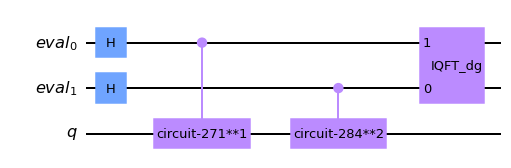

In [8]:
from qiskit.circuit.library import PhaseEstimation

pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

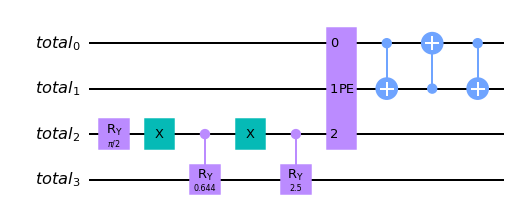

In [34]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[2:])
total_circuit.append(pe.to_gate(), qr_total[0:3])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()
#qstexp1 = StateTomography(total_circuit, measurement_qubits=[0,1])
#qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
#for result in qstdata1.analysis_results():
#    print(result)
total_circuit.decompose().draw("mpl")

In [43]:
state_result = qstdata1.analysis_results("state")
print(state_result.value)
print('probabilities: ',np.diag(state_result.value)),len(np.diag(state_result.value))

DensityMatrix([[ 0.1310109 +0.00000000e+00j, -0.03555768-1.61494362e-01j,
                 0.04008006-3.21978614e-02j,  0.12426907-3.97390130e-02j],
               [-0.03555768+1.61494362e-01j,  0.34078039+1.04426080e-17j,
                 0.02978024+2.63019288e-01j,  0.03555768+2.50835072e-01j],
               [ 0.04008006+3.21978614e-02j,  0.02978024-2.63019288e-01j,
                 0.33802172-2.86017124e-18j,  0.18269516-1.24724936e-02j],
               [ 0.12426907+3.97390130e-02j,  0.03555768-2.50835072e-01j,
                 0.18269516+1.24724936e-02j,  0.190187  +1.44079142e-18j]],
              dims=(2, 2))
probabilities:  [0.1310109 +0.00000000e+00j 0.34078039+1.04426080e-17j
 0.33802172-2.86017124e-18j 0.190187  +1.44079142e-18j]


(None, 4)

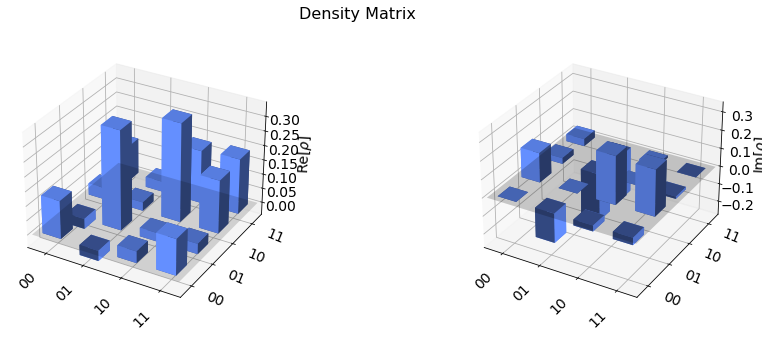

In [44]:
plot_state_city(state_result.value.data, title='Density Matrix')

In [45]:
state_result.extra

{'trace': 0.9999999999999968,
 'eigvals': array([0.82657925, 0.17342075, 0.        , 0.        ]),
 'raw_eigvals': array([ 1.37061215,  0.71745365, -0.29318422, -0.79488158]),
 'rescaled_psd': True,
 'fitter_metadata': {'fitter': 'linear_inversion',
  'fitter_time': 0.0003361701965332031}}

In [18]:
diag = np.diag(state_result.value)
diag/np.sqrt(382/1641)

array([0.14356102+0.00000000e+00j, 0.96787526-2.14348325e-17j,
       0.73771767+1.60236893e-17j, 0.22348001-1.32963638e-35j])

In [36]:
from qiskit.visualization import plot_histogram

backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
counts = job.result().get_statevector()
#plot_histogram(counts)

In [32]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=4)))]

In [73]:
list(zip(bitstrings,np.asarray(counts)))

[('0000', (8.326672684688674e-17+1.6064663921223203e-16j)),
 ('0001', (0.22360679774997877+8.559210290846823e-17j)),
 ('0010', (0.4472135954999579-3.0627050101867916e-16j)),
 ('0011', (5.551115123125783e-17+6.003175889797888e-17j)),
 ('0100', (5.551115123125783e-17+7.648655852791526e-17j)),
 ('0101', (-0.223606797749979+2.643490518101255e-17j)),
 ('0110', (0.44721359549995787-1.9416902436752405e-16j)),
 ('0111', (1.3877787807814457e-17+9.124756065859624e-17j)),
 ('1000', (2.7755575615628914e-17+9.839163523524156e-17j)),
 ('1001', (-0.2236067977499791+1.026606071414222e-16j)),
 ('1010', (0.447213595499958-2.507685705943865e-16j)),
 ('1011', (9.71445146547012e-17+4.9716328217722734e-17j)),
 ('1100', (8.326672684688674e-17+1.3933682549399297e-16j)),
 ('1101', (0.22360679774997894+3.821037155929212e-17j)),
 ('1110', (0.4472135954999579-2.294495360691823e-16j)),
 ('1111', (5.551115123125783e-17+5.190233901589717e-17j))]

In [75]:
#TODO:generalizzare il 2048/1641.

np_sqrt=np.sqrt(np.asarray(counts)**2 *2048/1641)
np_sqrt

array([9.30212516e-17+1.79466061e-16j, 2.49801872e-01+9.56190407e-17j,
       4.99603743e-01-3.42149457e-16j, 6.20141678e-17+6.70643553e-17j,
       6.20141678e-17+8.54468006e-17j, 2.49801872e-01-2.95316996e-17j,
       4.99603743e-01-2.16915524e-16j, 1.55035419e-17+1.01937024e-16j,
       3.10070839e-17+1.09918012e-16j, 2.49801872e-01-1.14687085e-16j,
       4.99603743e-01-2.80145590e-16j, 1.08524794e-16+5.55404932e-17j,
       9.30212516e-17+1.55659846e-16j, 2.49801872e-01+4.26866375e-17j,
       4.99603743e-01-2.56329075e-16j, 6.20141678e-17+5.79825907e-17j])

In [56]:
list(zip(bitstrings,np_sqrt.round(4)))

[('0000', 0j),
 ('0001', (0.2498+0j)),
 ('0010', (0.4996-0j)),
 ('0011', 0j),
 ('0100', 0j),
 ('0101', (0.2498-0j)),
 ('0110', (0.4996-0j)),
 ('0111', 0j),
 ('1000', 0j),
 ('1001', (0.2498-0j)),
 ('1010', (0.4996-0j)),
 ('1011', 0j),
 ('1100', 0j),
 ('1101', (0.2498+0j)),
 ('1110', (0.4996-0j)),
 ('1111', 0j)]

In [29]:
np.sum(np.dot(counts,counts.T))

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_11073/1807836436.py:1: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  np.sum(np.dot(counts,counts.T))


(0.9999999999999999-8.794939696570129e-16j)

$$\left|\psi\right\rangle=0.4996|0010\rangle+0.4996|0110\rangle+0.4996|1010\rangle+0.4996|1110\rangle .$$

$$\begin{aligned}
\left|\psi\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle .
\end{aligned}$$

$$\left|\psi\right\rangle=0.4996|1000\rangle+0.4996|1001\rangle+0.4996|1010\rangle+0.4996|1011\rangle .$$


$$0.4996*|10\rangle(|0\rangle|0\rangle+|0\rangle|1\rangle+|1\rangle|0\rangle+|1\rangle|1\rangle) .$$


In [41]:
np.sqrt(382/2048), np.sqrt(410/2048),np.sqrt(412/2048),np.sqrt(437/2048)

(0.4318835925339142,
 0.44743190822738604,
 0.44852187795022885,
 0.46192954684670257)

In [70]:
np.linalg.eig(example_matrix)

(array([2., 1.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))